Epoch 0, Loss: 0.7242, Train Accuracy: 0.4641
Epoch 20, Loss: 0.6664, Train Accuracy: 0.6143
Epoch 40, Loss: 0.6545, Train Accuracy: 0.5808
Epoch 60, Loss: 0.6418, Train Accuracy: 0.6126
Epoch 80, Loss: 0.6297, Train Accuracy: 0.6158
Epoch 100, Loss: 0.6180, Train Accuracy: 0.6720
Epoch 120, Loss: 0.6066, Train Accuracy: 0.6720
Epoch 140, Loss: 0.5957, Train Accuracy: 0.6720
Epoch 160, Loss: 0.5851, Train Accuracy: 0.6718
Epoch 180, Loss: 0.5750, Train Accuracy: 0.6718
Test Accuracy: 0.9634308218955994


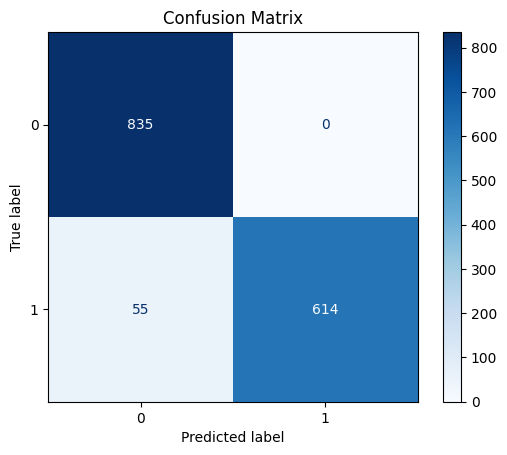

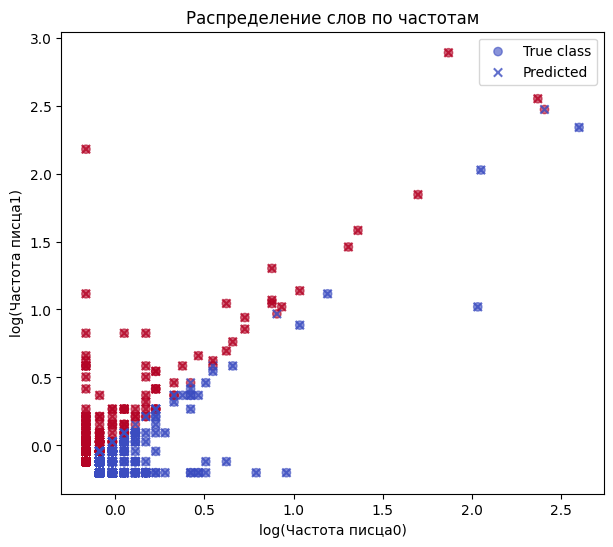

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

# загрузка данных
df = pd.read_csv("/Users/ann/Desktop/gospels/VEC2.csv", index_col=0)
df_t = df.T

X = df_t.values
y = np.argmax(X, axis=1)

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# нормализация
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# преобразуем в torch.Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)

# модель
class ScribeClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(X_train.shape[1], len(np.unique(y)))

    def forward(self, x):
        return self.linear(x)

model = ScribeClassifier()

# функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# цикл обучения
for epoch in range(200):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        with torch.no_grad():
            preds_train = torch.argmax(outputs, dim=1)
            acc_train = (preds_train == y_train).float().mean()
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Train Accuracy: {acc_train.item():.4f}")

# проверка на тесте
with torch.no_grad():
    preds_test = torch.argmax(model(X_test), dim=1)
    acc_test = (preds_test == y_test).float().mean()
    print("Test Accuracy:", acc_test.item())

# матрица ошибок
cm = confusion_matrix(y_test.numpy(), preds_test.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# scatter plot
if X_train.shape[1] == 2:
    plt.figure(figsize=(7,6))
    plt.scatter(np.log1p(X_test[:,0]), np.log1p(X_test[:,1]), c=y_test, cmap='coolwarm', alpha=0.6, label='True class')
    plt.scatter(np.log1p(X_test[:,0]), np.log1p(X_test[:,1]), c=preds_test, cmap='coolwarm', marker='x', alpha=0.8, label='Predicted')
    plt.xlabel('log(Частота писца0)')
    plt.ylabel('log(Частота писца1)')
    plt.title('Распределение слов по частотам')
    plt.legend()
    plt.show()
